In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn import datasets
import time



# Importando os dados

In [ ]:
iris = datasets.load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [ ]:
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


# Construindo Dataset

In [ ]:
class IrisDataset(Dataset):
    def __init__(self, df):
        # X como float32 e y como int64
        self.x = df.drop(columns=['target']).to_numpy(dtype='float32')
        self.y = df['target'].to_numpy(dtype='int64')

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        # from_numpy evita cópia desnecessária
        x = torch.from_numpy(self.x[index])                 # float32
        y = torch.tensor(self.y[index], dtype=torch.long)   # int64 (classe)
        return x, y

In [ ]:
iris_dataset = IrisDataset(iris_df)


In [ ]:
train_size = int(0.54 * len(iris_dataset))
test_size = int(0.345 * len(iris_dataset))
validation_size = len(iris_dataset) - train_size - test_size

train_dataset, test_dataset, validation_dataset = random_split(iris_dataset,[train_size, test_size,validation_size])

train_loader = DataLoader(train_dataset,batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=10, shuffle=True)
validation_loader = DataLoader(validation_dataset,batch_size=10, shuffle=True)


In [ ]:
x, y = next(iter(train_loader))
print("X shape:", x.shape)
print("y shape:", y.shape)


X shape: torch.Size([10, 4])
y shape: torch.Size([10])


# Rede implementada

In [ ]:
class iris_net(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(4,4),
        nn.ReLU(),
        nn.Linear(4,4),
        nn.ReLU(),
        nn.Linear(4,3),
    )

  def forward(self,x):
    return self.layers(x)


# Modelo , função de perda e otimizador

In [ ]:
model = iris_net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Treinamento do modelo

In [ ]:
def train_and_validate_model(model, training_loader,validation_loader,criterion, optimizer, epochs=10):

  epoch_time = 0.0
  training_losses = []
  training_accuracies = []
  validation_losses = []
  validation_accuracies = []
  correct_pred = 0
  validation_correct_pred = 0

  for epoch in range(epochs):
    training_epoch_loss = 0.0
    validation_epoch_loss = 0.0
    training_correct_pred = 0
    validation_correct_pred = 0
    training_y_total = 0
    validation_y_total = 0

    start_time = time.time() #O objetivo aqui é identificar quanto tempo esta durando cada epoca
    model.train()
    for batch_idx, (x,y) in enumerate(training_loader):

      y_pred = model(x)
      training_loss = criterion(y_pred, y)
      #Zera os gradientes acumulados
      optimizer.zero_grad()
      # Computa os gradientes
      training_loss.backward()
      #Caminha em direção a redução do erro
      optimizer.step()
      #loss é um tensor; item para obter o float
      training_epoch_loss += training_loss.item()

      #Acurácia:
      pred_result = y_pred.argmax(dim=1)
      training_correct_pred += (pred_result == y).sum().item()
      training_y_total += y.size(0)


    training_mean_loss = training_epoch_loss/len(training_loader)
    training_losses.append(training_mean_loss)
    training_acc = training_correct_pred / training_y_total
    training_accuracies.append(training_acc)

    model.eval()
    pred_result = 0
    with torch.no_grad():
      for batch_idx, (x,y) in enumerate(validation_loader):
        y_pred = model(x)
        validation_loss = criterion(y_pred, y)
        validation_epoch_loss += validation_loss.item()

        #Acurácia
        pred_result = y_pred.argmax(dim=1)
        validation_correct_pred += (pred_result == y).sum().item()
        validation_y_total += y.size(0)
    validation_mean_loss = validation_epoch_loss/len(validation_loader)
    validation_losses.append(validation_mean_loss)
    validation_acc = validation_correct_pred / validation_y_total
    validation_accuracies.append(validation_acc)

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"epoch: {epoch} training loss: {training_mean_loss}  || training accuracy: {training_acc} || validation loss: {validation_mean_loss} || validation accuracy: {validation_acc} || time: {epoch_time} ")

  return training_losses, validation_losses, training_accuracies, validation_accuracies


In [ ]:
model = iris_net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 500

training_losses, validation_losses, training_accuracies, validation_accuracies = train_and_validate_model(model, train_loader, validation_loader, criterion, optimizer, epochs)

epoch: 0 training loss: 1.3733256393008761  || training accuracy: 0.30864197530864196 || validation loss: 1.159283459186554 || validation accuracy: 0.4444444444444444 || time: 0.01849818229675293 
epoch: 1 training loss: 1.3346592055426703  || training accuracy: 0.30864197530864196 || validation loss: 1.156070590019226 || validation accuracy: 0.4444444444444444 || time: 0.013165473937988281 
epoch: 2 training loss: 1.3199784755706787  || training accuracy: 0.30864197530864196 || validation loss: 1.152914047241211 || validation accuracy: 0.4444444444444444 || time: 0.012354850769042969 
epoch: 3 training loss: 1.2817868656582303  || training accuracy: 0.30864197530864196 || validation loss: 1.1504626274108887 || validation accuracy: 0.4444444444444444 || time: 0.012585878372192383 
epoch: 4 training loss: 1.2631873819563124  || training accuracy: 0.30864197530864196 || validation loss: 1.1282587051391602 || validation accuracy: 0.4444444444444444 || time: 0.012777328491210938 
epoch: 5 

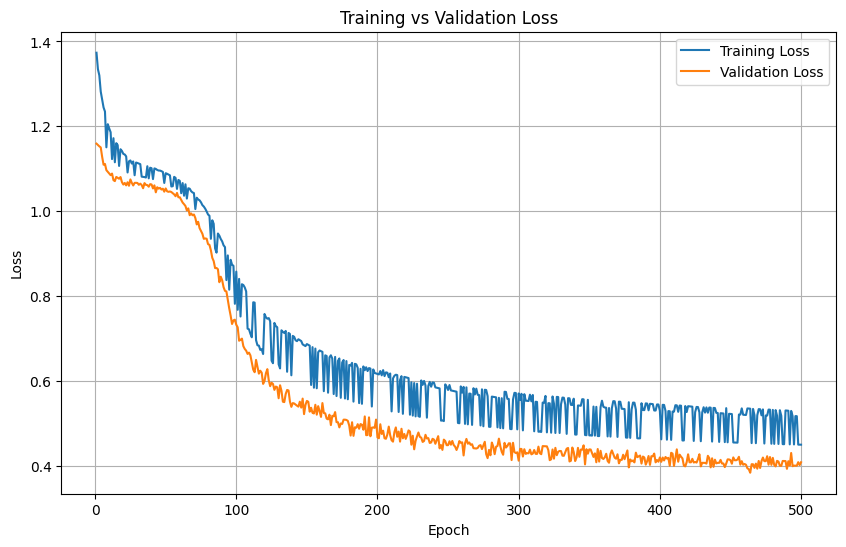

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), training_losses, label="Training Loss")
plt.plot(range(1, epochs+1), validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


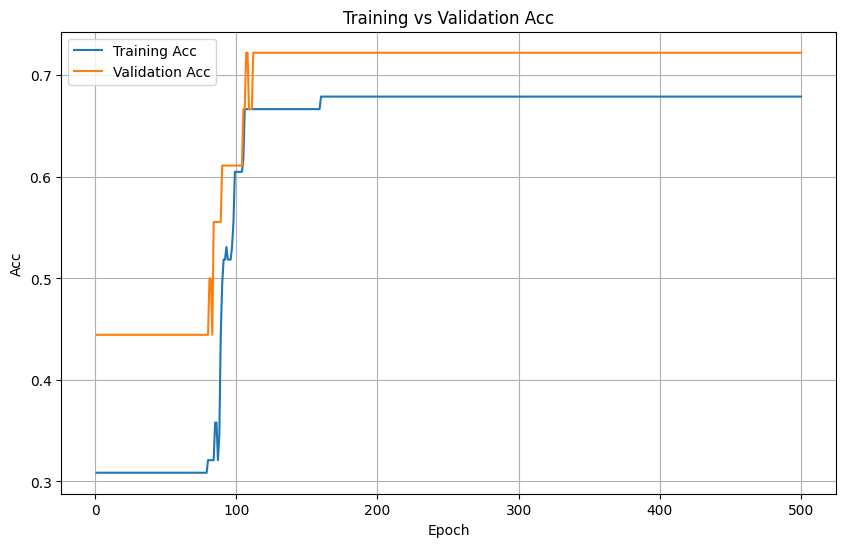

In [ ]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), training_accuracies, label="Training Acc")
plt.plot(range(1, epochs+1), validation_accuracies, label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.title("Training vs Validation Acc")
plt.legend()
plt.grid(True)
plt.show()